# Sam 1.1 Tutorial

This document is a tutorial for how to use sam to train a 'decent' model easily, and how to go from there, using the sam package.

The used data can be found on the NAS, as 'ChicagoWater.feather'

## Goals of this document

* Start with data in SAM format, even with issues such as missing values and non-uniform timestamps
* Show the complete steps to getting a working model with little effort, that performs significantly better than the benchmark
* Show the additional features and possibilities for extending/changing the model

## Table of contents

1. Loading the data
2. Preparing the data for SamQuantileMLP
3. Fitting the SamQuantileMLP
4. Making and interpreting predictions
5. Diagnostics and other features
6. Improving and extending the model
7. Training an LSTM instead (coming in the future!)

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
from pathlib import Path

import os
# Hide some of the tensorflow warnings, only to make the notebook more readable
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
# Hide the FutureWarnings thrown by tensorflow, to make the notebook more readable
warnings.simplefilter("ignore", category=FutureWarning)

import sam
from sam.models import SamQuantileMLP
from sam.preprocessing import sam_format_to_wide

import pandas as pd
import numpy as np
import tensorflow as tf
# Hide some of the tensorflow warnings, only to make the notebook more readable
tf.logging.set_verbosity(tf.logging.ERROR)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Set the folder to read data from
datafolder = Path('../data')

# We configure tensorflow to not take up all GPU memory. Useful when sharing a GPU with others
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

# Part 1 - Loading the data

The first thing we do is read some data in 'SAM' format. This format is the following columns:
* TIME - the timestamp of the measurement
* ID - the name or location of the sensor
* TYPE - the type of the sensor, or what it is measuring
* VALUE - the value of the measurement

If your data is not in this format, try bringing it into this format. If your data is in wide format, you can use `sam.preprocessing.wide_to_sam_format`. However, this is not neccecary, since we will shortly convert to wide format anyway. Unfortunately, since this preprocessing is very data-specific, we cannot give any specific pointers here.

We have to do some data specific preprocessing: we will decide to focus only on 'Oak Street Weather Station' and 'Ohio Street Beach'.
This is obviously data-specific, so we will not dwell on this too long.

In [2]:
data = pd.read_feather(datafolder / 'ChicagoWater.feather')

# Data-specific preprocessing: for this demo, we just take one beach and one weather station
data = data.loc[data['ID'].isin(['Ohio Street Beach', 'Oak Street Weather Station'])]
# Data-specific processing: This type is almost only nans, so we just get rid of it
data = data.loc[data['TYPE'] != 'Transducer Depth']

# Here, we show the locations, and timestamps
# It looks like we have about 6 years of data, but for more in-depth insights, use the sam-exploration dashboard instead
display(data.TIME.min())
display(data.TIME.max())
display(data.ID.unique())
data.head()

Timestamp('2013-09-03 03:00:00')

Timestamp('2018-08-07 10:00:00')

array(['Ohio Street Beach', 'Oak Street Weather Station'], dtype=object)

,ID,TIME,TYPE,VALUE
109560,Ohio Street Beach,2013-09-03 03:00:00,Water Temperature,21.9
109561,Ohio Street Beach,2014-06-05 12:00:00,Water Temperature,16.9
109562,Ohio Street Beach,2014-06-06 14:00:00,Water Temperature,18.8
109563,Ohio Street Beach,2014-06-06 17:00:00,Water Temperature,19.8
109564,Ohio Street Beach,2014-06-06 18:00:00,Water Temperature,19.7


# Part 2 - Preparing the data for SamQuantileMLP

The SamQuantileMLP does a lot of processing by itself, but there are a few things that (for now) need to be handled before inputting. In order:

1. The data needs to be in wide format. For this, we can use `sam.preprocessing.sam_format_to_wide`.

2. The data needs to be monospaced. Our data is not monospaced yet, since the winters are missing.
     - For making the data monospaced, we recommend to use `pd.resample`. This method does not work if there are duplicate timestamps, in which case you can use `sam.preprocessing.normalize_timestamp`

3. X_train, X_test, y_train, y_test need to be split. In our case, we will use sklearn `train_test_split`, and `Ohio Street Beach_Water Temperature` as the target

4. The data needs to be imputed. The target does not need to be imputed, since the SamQuantileMLP will automatically throw away rows where the target is missing
     - Imputation is done in SamQuantileMLP, but only after the rolling features. This means many rolling windows will fail, making the feature engineering less useful.
      This may be improved in the future, so for now it is recommended to impute your data beforehand.

In [3]:
# Step 1
data_wide = sam.preprocessing.sam_format_to_wide(data)
data_wide.head()

,TIME,Oak Street Weather Station_Air Temperature,Oak Street Weather Station_Barometric Pressure,Oak Street Weather Station_Battery Life,Oak Street Weather Station_Heading,Oak Street Weather Station_Humidity,Oak Street Weather Station_Interval Rain,Oak Street Weather Station_Maximum Wind Speed,Oak Street Weather Station_Precipitation Type,Oak Street Weather Station_Rain Intensity,Oak Street Weather Station_Solar Radiation,Oak Street Weather Station_Total Rain,Oak Street Weather Station_Wet Bulb Temperature,Oak Street Weather Station_Wind Direction,Oak Street Weather Station_Wind Speed,Ohio Street Beach_Battery Life,Ohio Street Beach_Turbidity,Ohio Street Beach_Water Temperature,Ohio Street Beach_Wave Height,Ohio Street Beach_Wave Period
0,2013-09-03 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.4,4.97,21.9,0.241,7.0
1,2014-06-05 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.8,1.60,16.9,0.159,3.0
2,2014-06-06 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.4,0.70,18.8,0.135,2.0
3,2014-06-06 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.3,0.78,19.8,0.162,3.0
4,2014-06-06 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.3,0.77,19.7,0.130,3.0


In [4]:
# Step 2

# For missing timestamps, we can choose to forwardfill or other 'smart' interpolation methods
# In our case we don't want to interpolate, we just want to ignore all the measurements in the winter, so we just fill then with nans
data_wide = (data_wide
             .set_index('TIME')  # resample requires a time index
             .resample('1H')  # Make sure the data is monospaced with a 1 hour indexs
             .asfreq(None)  # fill all new values with nans
             .reset_index()
            )

In [5]:
# Step 3

# Now let's create train/test set
targetname = 'Ohio Street Beach_Water Temperature'

target = data_wide[targetname]
data_wide = data_wide.drop(targetname, axis=1)

# Keep in mind to use `shuffle=False`, since we want the test to be *after* the train, not intermixed
X_train, X_test, y_train, y_test = train_test_split(data_wide, target, test_size=0.33, shuffle=False)

In [6]:
# Step 4

# Now we will impute X_train and X_test
# Again, this may be added to SamQuantileMLP in the future.

# This is an extremely basic imputation method. In a real project, consider a 'better' method
X_train = X_train.ffill().bfill()
X_test = X_test.ffill().bfill()

# Part 3 - Fitting the SamQuantileMLP

Here, we will create and fit a SamQuantileMLP with near-default parameters, but still explicitly mention and explain the parameters

Note that the model, by default, does differencing when predicting the future! This should not be noticable to the user, but it means that for predicting,
the current value of the  target is required, to be able to predict the future value.

In [7]:
model = SamQuantileMLP(
     predict_ahead=5,  # We will predict 5 timestep ahead. NOTE: you can also predict the present by setting this to 0, or predict multiple timesteps by passing a list
     quantiles=(0.3, 0.7),  # We will predict two quantiles. NOTE: by default, no quantiles are predicted
     use_y_as_feature=True,  # We will use y as a feature in our model
     timecol='TIME',  # We will use 'TIME' as a feature column. NOTE: by default, the model assumes there is no time column
     time_components=['hour', 'weekday'],  # We will use these components as features
     time_cyclicals=['hour', 'weekday'],  # We will use these components as cyclical features instead of regular
     rolling_window_size=(4, 19),  # We will use this window size to calculate rolling features. 19 makes sense because it is exactly a day before our prediction 5 timesteps ahead.
     rolling_features=['lag'],  # We will calculate these rolling features
    
    # Note: For these parameters, see `sam.models.keras_quantile_mlp`
     n_neurons=200,  # Our MLP will use this many neurons
     n_layers=2,  # Our MLP will use this many layers
     batch_size=16,  # Our MLP will have this batch size
     epochs=10,  # Our MLP will use this many epochs
     lr=0.001,  # Our MLP will use this learning rate
     dropout=0.5,  # Our MLP will use this dropout rate (None for no dropout)
     momentum=None,  # Our MLP will use this batchnorm rate (None for no batchnorm )
     verbose=True  # Our MLP will have this verbosity
)

# Now fit the model. This method has an almost identical signature to the regular Keras Sequential fit method (https://keras.io/models/sequential/)
history = model.fit(X_train, y_train, validation_data = (X_test, y_test))



Train on 6325 samples, validate on 4060 samples
Epoch 1/10
6325/6325 [==============================] - 2s 368us/sample - loss: 1.8150 - val_loss: 0.8526
Epoch 2/10
6325/6325 [==============================] - 1s 237us/sample - loss: 1.2300 - val_loss: 0.8254
Epoch 3/10
6325/6325 [==============================] - 2s 238us/sample - loss: 1.0879 - val_loss: 0.7995
Epoch 4/10
6325/6325 [==============================] - 1s 237us/sample - loss: 0.9622 - val_loss: 0.7751
Epoch 5/10
6325/6325 [==============================] - 2s 239us/sample - loss: 0.9043 - val_loss: 0.7459
Epoch 6/10
6325/6325 [==============================] - 1s 235us/sample - loss: 0.9351 - val_loss: 0.7943
Epoch 7/10
6325/6325 [==============================] - 1s 235us/sample - loss: 0.9012 - val_loss: 0.7652
Epoch 8/10
6325/6325 [==============================] - 2s 239us/sample - loss: 0.8946 - val_loss: 0.7346
Epoch 9/10
6325/6325 [==============================] - 1s 235us/sample - loss: 0.8519 - val_loss: 0.752

In [8]:
# Show the features passed to the keras model
print(model.get_feature_names())

# Note that the model.score method should give the same output as the val_loss above:
print("\nval_loss:", model.score(X_test, y_test))

['Oak Street Weather Station_Air Temperature#lag_4', 'Oak Street Weather Station_Barometric Pressure#lag_4', 'Oak Street Weather Station_Battery Life#lag_4', 'Oak Street Weather Station_Heading#lag_4', 'Oak Street Weather Station_Humidity#lag_4', 'Oak Street Weather Station_Interval Rain#lag_4', 'Oak Street Weather Station_Maximum Wind Speed#lag_4', 'Oak Street Weather Station_Precipitation Type#lag_4', 'Oak Street Weather Station_Rain Intensity#lag_4', 'Oak Street Weather Station_Solar Radiation#lag_4', 'Oak Street Weather Station_Total Rain#lag_4', 'Oak Street Weather Station_Wet Bulb Temperature#lag_4', 'Oak Street Weather Station_Wind Direction#lag_4', 'Oak Street Weather Station_Wind Speed#lag_4', 'Ohio Street Beach_Battery Life#lag_4', 'Ohio Street Beach_Turbidity#lag_4', 'Ohio Street Beach_Wave Height#lag_4', 'Ohio Street Beach_Wave Period#lag_4', 'y_#lag_4', 'Oak Street Weather Station_Air Temperature#lag_19', 'Oak Street Weather Station_Barometric Pressure#lag_19', 'Oak Street

# 4. Making and interpreting the prediction

Making a prediction is simple with `model.predict(X_test, y_test)`. Note that, because we use y as a feature, and also do differencing, we need to pass the *present* value of `y` to the predict function. Note that this is not 'cheating', because we are actually predicting the future value, not the present value.

Also note that the transformer will build rolling features from scratch. If `X_test` is not large enough (for example, only 12 datapoints when you need a window of 24), all the predictions will be nan.

In [9]:
prediction = model.predict(X_test, y_test)
# Note that we are showing the tail, not the head. Due to incomplete rolling windows, the first couple of predictions are always nan
prediction.tail(5)

,predict_lead_5_q_0.3,predict_lead_5_q_0.7,predict_lead_5_mean
43179,23.346641,23.717753,23.516434
43180,23.229255,23.559990,23.397897
43181,23.443978,23.869128,23.633140
43182,23.632196,24.049843,23.821854
43183,23.772809,24.163323,23.946742


The prediction has three columns, pertaining to `lead_5`. This means that for the datapoint in that row, when we predict 1 timestep ahead, our predictions are as such.
Of course, we might want to know more about this prediction, compare it to the true value, etcetera. We can do the following things:

* Get the data and timestamp for each prediction: join `X_test` and `prediction` on index: They have the same index, and `X_test` contains data and timestamp at which the prediction was made (not the timestamp that the prediction pertains to!)
* Get the current value of the target, at the time each prediction was made: Join `y_test` and `prediction` on index. This is useful, for instance when you want to compare to the persistence benchmark. Simply predicting `y_test` would be the same as the persistence benchmark.
* Get the 'actual' value in hindsight, for evaluating the model. This is done with `model.get_actual(y_test)`. This function will return a dataframe similar to `prediction`, but with the 'true' values. This is used for evaluating the model.

In [10]:
actual = model.get_actual(y_test)
# Note that we are predicting 5 timesteps ahead. Therefore the last timesteps have no 'actual' value: we have no data about what the 'true' value would be 1 step in the future.
# If we would be predicting multiple timesteps (for example: 1, 2 and 3 timesteps ahead), this function returns a dataframe instead of a series
actual.tail(10)

43174    23.3
43175    23.3
43176    23.3
43177    23.5
43178     NaN
43179     NaN
43180     NaN
43181     NaN
43182     NaN
43183     NaN
dtype: float64

In [11]:
# Combine everything:

# We ignore the quantile predictions for now.
all_prediction_data = pd.DataFrame({
    'TIME': X_test['TIME'],
    'actual': model.get_actual(y_test),
    'persistence': y_test,
    'prediction': prediction['predict_lead_5_mean']
})
all_prediction_data.tail(10)

,TIME,actual,persistence,prediction
43174,2018-08-07 01:00:00,23.3,23.7,23.553070
43175,2018-08-07 02:00:00,23.3,23.6,23.503781
43176,2018-08-07 03:00:00,23.3,23.5,23.444521
43177,2018-08-07 04:00:00,23.5,23.4,23.395161
43178,2018-08-07 05:00:00,NaN,NaN,NaN
43179,2018-08-07 06:00:00,NaN,23.3,23.516434
43180,2018-08-07 07:00:00,NaN,23.3,23.397897
43181,2018-08-07 08:00:00,NaN,23.3,23.633140
43182,2018-08-07 09:00:00,NaN,23.5,23.821854
43183,2018-08-07 10:00:00,NaN,23.7,23.946742


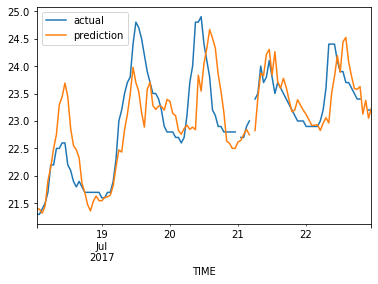

In [41]:
# Show the prediction vs the actual value
# There is not (yet) a single plotting solution
# So here, we just show a single way to plot a prediction
%matplotlib inline

(all_prediction_data
   .loc[all_prediction_data['TIME'] > '2017-07-18 00:00:00']
   .loc[all_prediction_data['TIME'] < '2017-07-23 00:00:00']
   .set_index('TIME')
   .loc[:, ['actual', 'prediction']]
).plot()

In [12]:
# Score the predictions

# Note that the performance isn't great yet due to the very basic feature engineering. Ask Fenno or Daan about progress on this, but better feature engineering is coming ASAP!
# Also, it may be worth tinkering with some of the parameters such as number of neurons, learning rate, dropout, etc. However, good feature engineering, from experience,
# has by far the biggest contribution to good performance.

# We dropna because mean_squared_error crashes if it gets passed nans

print('model MSE:')
print(mean_squared_error(all_prediction_data.dropna()['actual'], all_prediction_data.dropna()['prediction']))


print('persistence benchmark:')
print(mean_squared_error(all_prediction_data.dropna()['actual'], all_prediction_data.dropna()['persistence']))

model MSE:
0.36348970684600324
persistence benchmark:
0.7820024630541873


# 5. Diagnostics and other features

In this section, we show how we can inspect the model and predictions in a bit more detail. Also, we show how to dump/load the model, and show a summary, because that didn't really fit in any other section

* quantile_feature_importances
* get_explainer
* plot (coming soon!)
* dump/load/summary

In [13]:
# Quantile Feature importance (ELI5)

# This will output a dataframe with n_iter rows, and a column for each column used in the model.
# The lower the score, the more important it is. If a certain column only has scores around 0, it is not a very important feature

# We only use 100 samples here. This is purely for performance reasons. The more data samples and the more iterations, the more accurate it will be.
score_decreases = model.quantile_feature_importances(X_test[-100:], y_test[-100:], n_iter=5)

Using TensorFlow backend.


In [14]:
# We can average the trials to get an approximate feature importance
feature_importances = score_decreases.mean().sort_values()
feature_importances

TIME_hour_sin                                            -0.337948
TIME_hour_cos                                            -0.147360
y_#lag_19                                                -0.048396
y_                                                       -0.030729
Oak Street Weather Station_Wet Bulb Temperature#lag_19   -0.022272
                                                            ...   
Oak Street Weather Station_Air Temperature#lag_4          0.001650
Oak Street Weather Station_Wet Bulb Temperature#lag_4     0.001675
Oak Street Weather Station_Total Rain#lag_19              0.002729
Oak Street Weather Station_Solar Radiation#lag_19         0.006177
Oak Street Weather Station_Heading#lag_4                  0.007839
Length: 61, dtype: float64

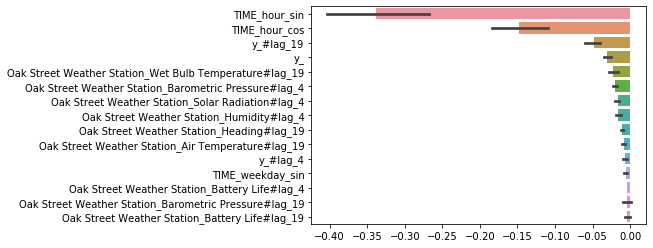

In [15]:
# Or we can show the score decreases with errorbars. Note that we only show the top 15 most importance features, since it would get too long otherwise
import seaborn
%matplotlib inline
chart = seaborn.barplot(data=score_decreases[feature_importances.index[:15]], orient='h')

/home/jovyan/my-conda-envs/r-tensorflow/lib/python3.7/site-packages/shap/explainers/deep/deep_tf.py:148: UserWarning: You have provided over 5k background samples! For better performance consider using smaller random sample.
  warnings.warn("You have provided over 5k background samples! For better performance consider using smaller random sample.")


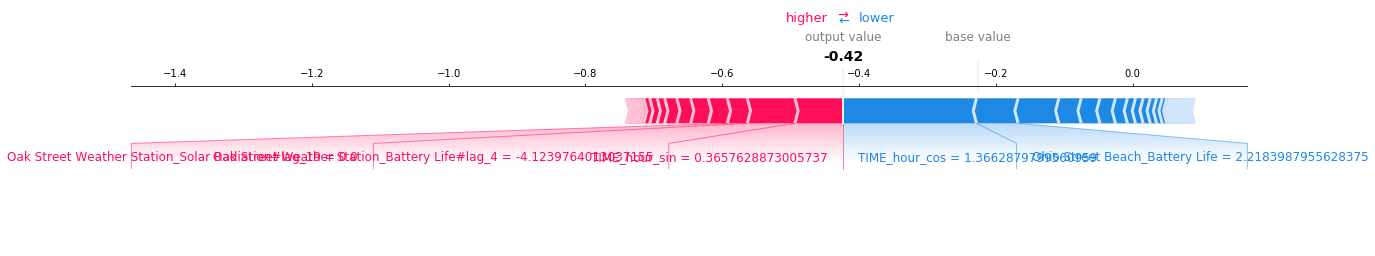

In [16]:
# SHAP

%matplotlib inline
import shap

# Obtain a SHAP explainer that works on our (non-keras) model
explainer = model.get_explainer(X_test, y_test)

shap_values = explainer.shap_values(X_test[0:10], y_test[0:10])
test_values = explainer.test_values(X_test[0:10], y_test[0:10])

# After obtaining shap values, we can use the normal force plot
shap.force_plot(explainer.expected_value[0], shap_values[0][-1,:], test_values.iloc[-1,:], matplotlib=True)

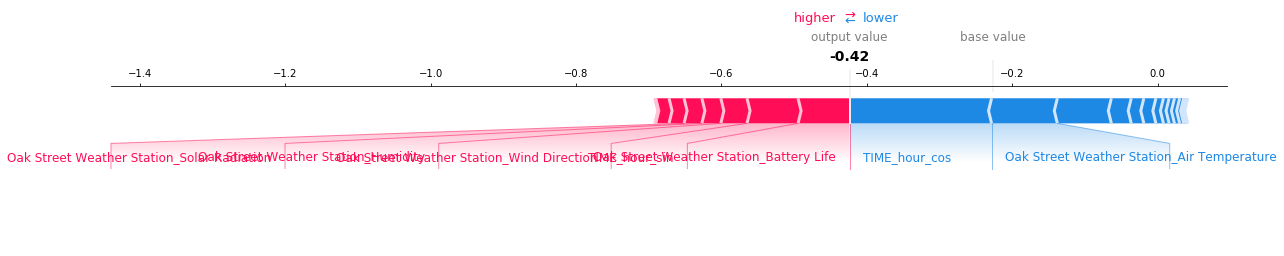

In [17]:
from sam.utils import sum_grouped_columns

# Code taken straight from http://10.2.0.20/sam/utils.html?highlight=sum#sam.utils.sum_grouped_columns
# Used to sum the shap values that come from the same feature
df = pd.DataFrame(shap_values[0], columns = model.get_feature_names(), index = X_test[0:10].index)
summed_shaps = sum_grouped_columns(df)
empty_X = pd.DataFrame(np.full_like(summed_shaps, "", dtype=str), columns=summed_shaps.columns)
shap.force_plot(explainer.expected_value[0], summed_shaps.values[-1,:], empty_X.iloc[-1,:], matplotlib=True)

# We see that, even though battery life is not that important overall, for this particular sample it seems to be quite important.

In [18]:
# You can dump and load
model.dump(foldername='../output', prefix='mymodel')

model = SamQuantileMLP.load(foldername='../output', prefix='mymodel')

# You can view summary
model.summary()

SamQuantileMLP(batch_size=16, dropout=0.5, epochs=10, lr=0.001, momentum=None,
               n_layers=2, n_neurons=200, predict_ahead=[5],
               quantiles=(0.3, 0.7), rolling_features=['lag'],
               rolling_window_size=(4, 19), time_components=['hour', 'weekday'],
               time_cyclicals=['hour', 'weekday'], timecol='TIME',
               use_y_as_feature=True, verbose=True)
['Oak Street Weather Station_Air Temperature#lag_4', 'Oak Street Weather Station_Barometric Pressure#lag_4', 'Oak Street Weather Station_Battery Life#lag_4', 'Oak Street Weather Station_Heading#lag_4', 'Oak Street Weather Station_Humidity#lag_4', 'Oak Street Weather Station_Interval Rain#lag_4', 'Oak Street Weather Station_Maximum Wind Speed#lag_4', 'Oak Street Weather Station_Precipitation Type#lag_4', 'Oak Street Weather Station_Rain Intensity#lag_4', 'Oak Street Weather Station_Solar Radiation#lag_4', 'Oak Street Weather Station_Total Rain#lag_4', 'Oak Street Weather Station_Wet Bulb Tem

# 6. Improving and extending the model

In the previous sections, we saw the model performed well, but not amazingly, likely at least in part due to the feature engineering.
Better feature engineering for the SAM model is in the pipeline (no pun intended), but in general, it may happen that for a project,
you want to add your own features or perform feature engineering yourself. This can be done in two ways:

* Perform the feature engineering before passing the data to SamQuantileMLP.
* Subclass SamQuantileMLP, and change the feature engineering.

There is no consensus yet on what is the best option, so for now, choose what you want, and report back to the SAM team about your findings!

The second option may need some explanation, so we will give an example here. Note that this approach is versatile, and can be used to change SamQuantileMLP in any way you want.

In [19]:
# Here, we show an example of subclassing and changing the SAM model. In this case, we are actually making it worse.
# However, you can change the model in any way you want, even making it better!

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

class MyBetterSamModel(SamQuantileMLP):
    
    def get_feature_engineer(self):
        # Function that returns an Sklearn transformer
        scaler = StandardScaler()
        imputer = SimpleImputer()
        return Pipeline([('scaler', scaler),
                         ('imputer', imputer)])
    
    # Note: When changing `get_feature_engineer`, this function should also be changed since they depends on the feature engineer.
    # It is not obvious what the feature names should be in general, especially because a lot of transformers output
    # numpy arrays. For that reason, we need an additional function to decide the feature names

    def set_feature_names(self, X, X_transformed):
        # Note that this function can access the fitted feature engineer with `self.feature_engineer_`
        # In this case, we are not changing the columns, so just return X.columns
        return X.columns

model = MyBetterSamModel(predict_ahead=5,  timecol=None, epochs=5)  # Our model cannot handle a time column, so we won't pass it

# We need to drop the timecol to prevent StandardScaler from crashing
history = model.fit(X_train.drop('TIME', axis=1), y_train,
                    validation_data = (X_test.drop('TIME', axis=1), y_test))
    

Train on 6325 samples, validate on 4060 samples


/home/jovyan/sam/sam/models/SamQuantileMLP.py:319: UserWarning: No timecolumn given. Make sure the data ismonospaced when given to this model!
  "monospaced when given to this model!"), UserWarning)


Epoch 1/5
6325/6325 [==============================] - 1s 236us/sample - loss: 0.9271 - val_loss: 0.7125
Epoch 2/5
6325/6325 [==============================] - 1s 190us/sample - loss: 0.7927 - val_loss: 0.6623
Epoch 3/5
6325/6325 [==============================] - 1s 188us/sample - loss: 0.7689 - val_loss: 0.7033
Epoch 4/5
6325/6325 [==============================] - 1s 188us/sample - loss: 0.7240 - val_loss: 0.6536
Epoch 5/5
6325/6325 [==============================] - 1s 187us/sample - loss: 0.7230 - val_loss: 0.6349


In [20]:
predictions = pd.DataFrame({
    'actual': model.get_actual(y_test),
    'persistence': y_test,
    'prediction': model.predict(X_test.drop('TIME', axis=1), y_test)  # note that since we are only predicting a single column, this will return a series
}).dropna()

print("Benchmark: ", mean_squared_error(predictions['actual'], predictions['persistence']))
print("Model: ", mean_squared_error(predictions['actual'], predictions['prediction']))

# As we can see, as expected, the model does worse than the default model (since we are doing no feature engineering)

/home/jovyan/sam/sam/models/SamQuantileMLP.py:319: UserWarning: No timecolumn given. Make sure the data ismonospaced when given to this model!
  "monospaced when given to this model!"), UserWarning)


Benchmark:  0.7820024630541873
Model:  0.6348778715782873


# 7. Training an LSTM instead

We cannot use SamQuantileMLP with `sam.models.create_keras_quantile_rnn` as a model instead of the default MLP. The reason for that is because lstm require 3d input.

If there is demand, expect SamQuantileRnn in the future!